<a href="https://colab.research.google.com/github/lapshinaaa/deep-learning-tasks/blob/main/DL4_transformers_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# `Transformers for Named Entity Recognition`

## 🧩 What You Will Learn in This Assignment

In this assignment, you will practice modern NLP tooling and learn how to:

1. Load datasets and pretrained models from the [Hugging Face Hub](https://huggingface.co)  
2. Manipulate text datasets using the [`datasets`](https://huggingface.co/docs/datasets/index) library  
3. Run and fine-tune transformers with the [`transformers`](https://huggingface.co/docs/transformers/index) library  
4. Prompt a large language model, using [Qwen2.5-7B-Instruct](https://huggingface.co/Qwen/Qwen2.5-7B-Instruct) as an example  
5. Optimize hyperparameters using [Optuna](https://optuna.org/)  

---

## 🎯 Task Overview  

You will work on a standard token classification task:  
Named Entity Recognition (NER).

The assignment is divided into three parts:

1. Data preparation and working with datasets from Hugging Face  
2. Large Language Model prompting  
3. Fine-tuning a transformer model

---

## 📚 Recommended Reading

Make sure to study the official guide on token classification:  
👉 https://huggingface.co/learn/nlp-course/chapter7/2

---

## 🔧 Notes

Wherever the assignment instructs you to use *wandb*, you may use any unblocked alternatives.

## `Part I. Loading and preprocessing`

### `Google Colab environment preparation`

Secrets in colab:

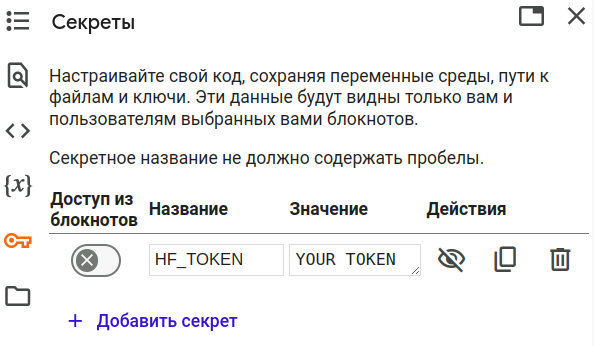

### `General Preprocessing`

In [1]:
# pip offers the --quiet / -q option to silence output

! pip install transformers[torch] datasets autoawq evaluate seqeval optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 30.4 MB/s eta 0:00:00


In [2]:
!pip freeze > requirements.txt
!cat requirements.txt | grep torch

torch==2.9.0+cu126
torchao==0.10.0
torchaudio==2.9.0+cu126
torchdata==0.11.0
torchsummary==1.5.1
torchtune==0.6.1
torchvision==0.24.0+cu126


In [3]:
!cat requirements.txt | grep transformers
!cat requirements.txt | grep datasets
!cat requirements.txt | grep autoawq
!cat requirements.txt | grep evaluate
!cat requirements.txt | grep seqeval
!cat requirements.txt | grep optuna

sentence-transformers==5.1.2
transformers==4.57.3
datasets==4.0.0
tensorflow-datasets==4.9.9
vega-datasets==0.9.0
autoawq==0.2.9
evaluate==0.4.6
seqeval==1.2.2
optuna==4.6.0


In [4]:
import gc
import json
import random
from typing import Any, Union
from pathlib import Path
from collections import Counter

import numpy as np
import numpy.typing as npt

import torch
import datasets
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TextGenerationPipeline,
    pipeline,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer
)
from transformers.trainer_callback import EarlyStoppingCallback

import optuna
import evaluate

torch.backends.cudnn.benchmark = True
torch.use_deterministic_algorithms(False)

torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.autograd.set_detect_anomaly(False)

torch.set_float32_matmul_precision('high')
torch.backends.cuda.matmul.allow_tf32 = True

/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


In [5]:
def set_global_seed(seed: int) -> None:
    """Set global seed for reproducibility.
    :param int seed: Seed to be set
    """
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def print_params_count(model):

    total_params = sum(p.numel() for p in model.parameters())
    total_params_grad = sum(p.numel() for p in model.parameters() if p.requires_grad)

    model_name = model.__class__.__name__
    print(f"Info about the number of model parameters: {model_name}")
    print(f"Overall params: \t\t {total_params}")
    print(f"Trainable params: \t {total_params_grad}")
    print()

set_global_seed(42)

In [6]:
if not torch.cuda.is_available():
    print("You need GPU!!!")

### `Loading Data`

First of all, Hugging Face --- is a hub with ready-to-use models and datasets. Upload a dataset [from here](https://huggingface.co/datasets/voorhs/conll2003-corrupted).

Tip: read [tutorial](https://huggingface.co/docs/datasets/load_hub).

In [7]:
from datasets import load_dataset

dataset = load_dataset("voorhs/conll2003-corrupted")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/309k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/281k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

**Question**: What fields are available to us? Print out a couple examples from each split. Try and guess what meaning each field has and describe it in two words.

*Tip:* read [tutorial](https://huggingface.co/docs/datasets/access).

In [ ]:
dataset['train'][0]

{'id': '473',
 'tokens': ['LONDON', '1996-08-22'],
 'pos_tags': [22, 11],
 'chunk_tags': [11, 12],
 'ner_tags': ['B-LOC', 'O']}

In [ ]:
dataset['validation'][2]

{'id': '2',
 'tokens': ['West',
  'Indian',
  'all-rounder',
  'Phil',
  'Simmons',
  'took',
  'four',
  'for',
  '38',
  'on',
  'Friday',
  'as',
  'Leicestershire',
  'beat',
  'Somerset',
  'by',
  'an',
  'innings',
  'and',
  '39',
  'runs',
  'in',
  'two',
  'days',
  'to',
  'take',
  'over',
  'at',
  'the',
  'head',
  'of',
  'the',
  'county',
  'championship',
  '.'],
 'pos_tags': [22,
  22,
  21,
  22,
  22,
  38,
  11,
  15,
  11,
  15,
  22,
  15,
  22,
  38,
  22,
  15,
  12,
  21,
  10,
  11,
  24,
  15,
  11,
  24,
  35,
  37,
  15,
  15,
  12,
  21,
  15,
  12,
  21,
  21,
  7],
 'chunk_tags': [11,
  12,
  12,
  12,
  12,
  21,
  11,
  13,
  11,
  13,
  11,
  13,
  11,
  21,
  11,
  13,
  11,
  12,
  0,
  11,
  12,
  13,
  11,
  12,
  21,
  22,
  13,
  13,
  11,
  12,
  13,
  11,
  12,
  12,
  0],
 'ner_tags': ['B-MISC',
  'I-MISC',
  'O',
  'B-PER',
  'I-PER',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-ORG',
  'O',
  'B-ORG',
  'O',
  'O',
  'O',
  'O'

In [ ]:
dataset['test'][3]

{'id': '3',
 'tokens': ['Japan',
  'began',
  'the',
  'defence',
  'of',
  'their',
  'Asian',
  'Cup',
  'title',
  'with',
  'a',
  'lucky',
  '2-1',
  'win',
  'against',
  'Syria',
  'in',
  'a',
  'Group',
  'C',
  'championship',
  'match',
  'on',
  'Friday',
  '.'],
 'pos_tags': [22,
  38,
  12,
  21,
  15,
  29,
  16,
  22,
  21,
  15,
  12,
  16,
  11,
  41,
  15,
  22,
  15,
  12,
  22,
  22,
  21,
  21,
  15,
  22,
  7],
 'chunk_tags': [11,
  21,
  11,
  12,
  13,
  11,
  12,
  12,
  12,
  13,
  11,
  12,
  12,
  21,
  13,
  11,
  13,
  11,
  12,
  12,
  12,
  12,
  13,
  11,
  0],
 'ner_tags': ['B-LOC',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-MISC',
  'I-MISC',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-LOC',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O']}

**Answer:**

### Dataset Fields Meaning

| Field        | Description                                                                 | Two-word summary |
|--------------|------------------------------------------------------------------------------|------------------|
| id         | Unique identifier of the sentence.                                           | sentence id      |
| tokens     | List of words in the sentence.                                               | word sequence    |
| pos_tags   | Part-of-speech tags encoded as integers.                                     | POS tags         |
| chunk_tags | Syntactic phrase/chunk labels encoded as integers (NP, VP, PP…).             | chunk labels     |
| ner_tags   | Named-entity labels in IOB2 format (e.g., B-LOC, I-MISC, O).                 | entity labels    |

### `Column Removal`

We will be predicting NER tags directly based on text. The remaining information is not needed. Remove all columns except `tokens` and `ner_tags`.

*Tip:* read [tutorial](https://huggingface.co/docs/datasets/process#remove).

In [8]:
dataset = dataset.remove_columns(["id", "pos_tags", "chunk_tags"])
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3453
    })
})

In [ ]:
# YOUR CODE IS HERE

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3453
    })
})

### `Collecting Tags (NER Label Exploration)`

Note that the dataset uses BIO-tagging.

BIO-tagging is a common annotation scheme for Named Entity Recognition (NER):
- B — *Beginning* of an entity  
- I — *Inside* the same entity  
- O — *Outside* (not part of any entity)

Examples:

- Sentence: *"Apple выпустила новый iPhone"*  
  BIO tags:  
  Apple/B-ORG выпустила/O новый/O iPhone/B-PRODUCT

- Sentence: *"Билл Гейтс основал Microsoft"*  
  BIO tags:  
  Билл/B-PER Гейтс/I-PER основал/O Microsoft/B-ORG

This format helps the model identify entity boundaries and types.

---

### Task

Before working with the dataset, we need to understand which NER tags are present.

Print all unique NER tag values found across the dataset.

*Hint:*  
You can iterate over a Hugging Face dataset using a usual for ... in ... loop.

---

### Question

Are there any suspicious tags that should not be present?

In [9]:
unique_NER_tags = set() # for storing unique tags

In [10]:
for split_name, split in dataset.items():
  for field in split:
    for tag in field['ner_tags']:
      unique_NER_tags.add(tag)

In [ ]:
unique_NER_tags

{'B-LOC',
 'B-MISC',
 'B-ORG',
 'B-PER',
 'I-LOC',
 'I-MISC',
 'I-ORG',
 'I-PER',
 'MISSING',
 'O'}

Or we can do it using a Counter

In [11]:
tag_counter = Counter()

for split_name, split in dataset.items():
    for row in split:
        tag_counter.update(row["ner_tags"])

print("NER tags and their frequencies:")
for tag, count in tag_counter.most_common():
    print(f"{tag:10s}  →  {count}")

NER tags and their frequencies:
O           →  201830
MISSING     →  58634
B-LOC       →  8561
B-PER       →  8127
B-ORG       →  7550
I-PER       →  5677
I-ORG       →  4287
B-MISC      →  4044
I-MISC      →  1355
I-LOC       →  1353


There is a "suspicious" tag: "MISSING" --> we will remove it

For loss and metric calculation we will need to turn tags into classes, since we'll be solving a classification problem.

Create tag mapping:
- `label2id`: string of a class (for example `B-PER`) -> index of this class
- `id2label`: vice versa

Remove suspicious tags.

*Tip:* there have to be 9 tags remaining

In [12]:
valid_tags = sorted([tag for tag in unique_NER_tags if tag != "MISSING"])

In [ ]:
valid_tags

In [13]:
id2label = valid_tags
id2label

['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

In [ ]:
# YOUR CODE IS HERE

id2label

['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

In [14]:
label2id = {label: i for i, label in enumerate(id2label)}
label2id

{'B-LOC': 0,
 'B-MISC': 1,
 'B-ORG': 2,
 'B-PER': 3,
 'I-LOC': 4,
 'I-MISC': 5,
 'I-ORG': 6,
 'I-PER': 7,
 'O': 8}

### `Filtering`

In the training part of the dataset for a portion of objects (data) isn't annotated. Split the training part into annotated and non-annotated objects. Print out the size of both of these portions.

*Tip:* read [tutorial](https://huggingface.co/docs/datasets/process#select-and-filter). Filtering can be done in one line.

In [15]:
train_missing = dataset['train'].filter(lambda x: "MISSING" in x['ner_tags'])
train_full = dataset['train'].filter(lambda x: "MISSING" not in x['ner_tags'])

len(train_missing)

Filter:   0%|          | 0/14041 [00:00<?, ? examples/s]

Filter:   0%|          | 0/14041 [00:00<?, ? examples/s]

4041

In [16]:
# YOUR CODE IS HERE
dataset_raw_essential = {}
dataset_raw_essential["train_missing"] = train_missing
dataset_raw_essential["train"] = train_full

dataset_raw_essential

{'train_missing': Dataset({
     features: ['tokens', 'ner_tags'],
     num_rows: 4041
 }),
 'train': Dataset({
     features: ['tokens', 'ner_tags'],
     num_rows: 10000
 })}

In [ ]:
assert len(dataset_raw_essential["train_missing"]) == 4041

### `Getting tokenizer-independent representation`

## Tokenizer-Independent Representation

The existing BIO annotation was produced using a tokenizer that is unknown to us.  
Therefore, we must build a tokenizer-independent representation of the dataset.

---

### 1. Reconstructing Text

For each dataset entry, you must join tokens from the field tokens into a single string and store it in field text.

Rules for spacing:

- punctuation marks, quotes, and parentheses  
  (`,`, ., !, ?, ), ", `'`)  
  must NOT have a space *before* them,  
  but must have a space *after* them.

Example:
- "Hello , world !" ❌ wrong  
- "Hello, world!" ✔ correct  
- "word ) next" ❌ wrong  
- "word) next" ✔ correct

---

### 2. Converting BIO Annotation

Since every tokenizer will split text differently, we need to build a representation of named entities that does not depend on tokenization.

Using the existing BIO tags:

1. Remove BIO prefixes (drop B- and `I-`), keeping only entity types  
   (PER, ORG, LOC, etc.)

2. For each named entity, determine the character-span in text  
   using Python slice format — [start, end].

---

### Example Output

```python
{
    'text': '6 - Andre Agassi (U.S.) vs. Mauricio Hadad (Colombia)',
    'tags': ['PER', 'LOC', 'PER', 'LOC'],
    'ranges': [[4, 16], [19, 23], [30, 44], [47, 55]]
}
```

Explanation:

In the text
'6 - Andre Agassi (U.S.) vs. Mauricio Hadad (Colombia)'
there are four named entities:

 • PER at positions [4, 16] → "Andre Agassi"

 • LOC at positions [19, 23] → "U.S."

 • PER at positions [30, 44] → "Mauricio Hadad"

 • LOC at positions [47, 55] → "Colombia"

⸻

# Important

 • Save the transformed dataset to disk (e.g., ./data/generic)

 • Refer to the docstring of transform_ner_data for precise argument names and expected return values

In [17]:
def transform_ner_data(tokens: list[str], ner_tags: list[str]):
    """
    Obtain tokenizer-independent representation of a single sample.

    Args:
        tokens: list of words, subwords or even punctuations
        ner_tags: list of BIO labels
    Returns:
        sample: dictionary with the following contents:
            - text (str): detokenized sequence
            - tags (list[str]): list of tags names (PER, ORG, LOC, MISC)
            - ranges (list[tuple[int, int]]): list of python slices for each entity
    """

    punctuation_symbols = ("-", "'", ".", ",", ")", ":", ";", '"')

    text = ""
    ranges = []
    tags = []

    # declare vars if you needed
    # YOUR CODE IS HERE

    curr_tag = None
    start_idx = None

    for token, tag in zip(tokens, ner_tags):
        # Adjust spacing based on token type
        if len(text) > 0 and not token.startswith(
            punctuation_symbols
        ):
            text += " "

        token_start = len(text)
        text += token
        token_end = len(text)

        # Handle entity tagging
        if tag.startswith("B-"):  # Begin a new entity
            # Close the previous entity if it was open
            if curr_tag is not None:
              tags.append(curr_tag)
              ranges.append([start_idx, prev_end])

            # start new entity (we just closed the previous one)
            curr_tag = tag[2:] # remove B-
            start_idx = token_start

        elif tag.startswith("I-"):  # Continue an entity
            # YOUR CODE IS HERE
            ent_type = tag[2:]

            # but if it doesn't match curr entity, we are starting a new one
            if curr_tag is None or ent_type != curr_tag:
              if curr_tag is not None:
                tags.append(curr_tag)
                ranges.append([start_idx, prev_end])

              # start new entity (we just closed the previous one)
              curr_tag = tag[2:] # remove B-
              start_idx = token_start


        else:  # Tag is "O" or unrelated, close any open entity
            # YOUR CODE IS HERE
            if curr_tag is not None:
              tags.append(curr_tag)
              ranges.append([start_idx, prev_end])
              curr_tag = None
              start_idx = None

        prev_end = token_end

    # Close any open entity at the end
    # YOUR CODE IS HERE
    if curr_tag is not None:
      tags.append(curr_tag)
      ranges.append([start_idx, prev_end])

    # Final output
    return {"text": text, "tags": tags, "ranges": ranges}

Make sure that everything works fine:

In [18]:
from datasets import DatasetDict

dataset_raw_essential = DatasetDict({
    "train": train_full,
    "train_missing": train_missing,
    "validation": dataset["validation"],
    "test": dataset["test"],
})

In [ ]:
dataset_raw_essential

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 10000
    })
    train_missing: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 4041
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3453
    })
})

In [19]:
dataset_generic = dataset_raw_essential.map(
    function=transform_ner_data,
    input_columns=["tokens", "ner_tags"],
    remove_columns=dataset_raw_essential["train"].column_names,
)

dataset_generic

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 10000
    })
    train_missing: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 4041
    })
    validation: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3453
    })
})

In [20]:
assert dataset_generic["train"][:3] == {
    "text": [
        "LONDON 1996-08-22",
        "WorldCom, which said it will buy MFS, shed 1-3/4 to close at 21 while MFS lost 3-8/16 to close at 41-5/16.",
        "6- Andre Agassi ( U.S.) vs. Mauricio Hadad ( Colombia)",
    ],
    "tags": [["LOC"], ["ORG", "ORG", "ORG"], ["PER", "LOC", "PER", "LOC"]],
    "ranges": [
        [[0, 6]],
        [[0, 8], [33, 36], [70, 73]],
        [[3, 15], [18, 22], [28, 42], [45, 53]],
    ],
}

Save the result to the disk (use functions from library `datasets`):

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
dataset_generic.save_to_disk('/content/drive/MyDrive/DL2/data')

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4041 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3250 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3453 [00:00<?, ? examples/s]

In [ ]:
# loading the dataset
from datasets import *
dataset_generic = load_from_disk('/content/drive/MyDrive/DL2/data')

### `Tokenization`

We'll be using the following tokenizer of the model `google-bert/bert-base-uncased`.

In [ ]:
from transformers import AutoTokenizer

bert_tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
print(bert_tokenizer(dataset_generic["train"]["text"][11]))

{'input_ids': [101, 3078, 3707, 6434, 2001, 27502, 1010, 6352, 11000, 1010, 2403, 1012, 1019, 3867, 2062, 2084, 2197, 2251, 1998, 1014, 1012, 1015, 3867, 2062, 2084, 1999, 2238, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Each tokenizer has its own special tokens. For getting this information the following variable can be used


In [ ]:
bert_tokenizer.all_special_ids

[100, 102, 0, 101, 103]

Now we need to write a function that, based on the existing tokenizer-independent representation, produces a BIO annotation aligned to the tokens of a provided tokenizer.

Implement the function `align_tokens_and_tags`, which transforms a single sample from the dataset.
All details about input/output format should be taken from the function’s docstring.

Important:
Special tokens added by the tokenizer must receive the label `SPECIAL_TOKENS_LABEL`, because they should NOT be included when computing the loss.

In [21]:
SPECIAL_TOKENS_LABEL = -100


def align_tokens_and_tags(
    text: str, tags: list[str], ranges: list[tuple[int, int]], tokenizer: AutoTokenizer
):
    """
    Align the tokenizer-independent representation with a Hugging Face tokenizer.

    Args:
        text: original text.
        tags: list of entity tags (e.g., ["PER", "LOC"]).
        ranges: list of (start, end) character ranges for each entity.
        tokenizer: A Hugging Face tokenizer.

    Returns:
        dict: A dictionary with `input_ids`, `labels`:
            - input_ids are tokens indices in tokenizer's vocabulary
            - labels are integer labels for BIO tags (from label2id mapping)

    Note:
        This function
    """
    encoding = tokenizer(
        text, return_offsets_mapping=True, truncation=True, padding=False
    )
    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"])
    token_ids = encoding["input_ids"]
    offset_mapping = encoding["offset_mapping"]


    # Initialize BIO tags for each token
    # YOUR CODE IS HERE
    labels=[]
    for token_id, (start, end) in zip(token_ids, offset_mapping):
      if token_id in tokenizer.all_special_ids:
        labels.append(SPECIAL_TOKENS_LABEL)
      else:
        labels.append(label2id["O"])

    # Map character ranges to token indices
    for tag, (start, end) in zip(tags, ranges):
        # Find tokens that overlap with the entity range
        for (i, (token_start, token_end)), token_id in zip(
            enumerate(offset_mapping), token_ids
        ):

            # detect no overlap
            # YOUR CODE IS HERE
            if token_end <= start or token_start >= end:
              continue # skip if no overlap
            # same for special tokens
            if token_id in tokenizer.all_special_ids:
              continue

            # classifier token
            #     hint: use if
            # classifier token: decide B- or I-
            # if previous token is NOT inside this entity → B
            if token_start == start:
              labels[i] = label2id[f"B-{tag}"]
            else:
              labels[i] = label2id[f"I-{tag}"]


    return {
        "input_ids": token_ids,
        "labels": labels # don't forget to handle special tokens
    }

In [22]:
def tokenize_ner_dataset(
    dataset: Union[datasets.DatasetDict, datasets.Dataset], tokenizer: AutoTokenizer
):
    return dataset.map(
        function=align_tokens_and_tags,
        input_columns=["text", "tags", "ranges"],
        fn_kwargs={"tokenizer": tokenizer},
        remove_columns=(
            dataset["train"] if "train" in dataset else dataset
        ).column_names,
    )

A few examples of what we should be getting:

In [ ]:
for i in range(9, 12):
    sample = dataset_generic["train"][i]
    print("before tokenization:", sample)
    tokenized_sample = align_tokens_and_tags(**sample, tokenizer=bert_tokenizer)
    print("after tokenization:", tokenized_sample)
    print()

before tokenization: {'text': '1-0.', 'tags': [], 'ranges': []}
after tokenization: {'input_ids': [101, 1015, 1011, 1014, 1012, 102], 'labels': [-100, 8, 8, 8, 8, -100]}

before tokenization: {'text': 'Puchon 3 Chonan 0 ( halftime 1-0)', 'tags': ['ORG', 'ORG'], 'ranges': [[0, 6], [9, 15]]}
after tokenization: {'input_ids': [101, 16405, 24561, 1017, 16480, 7229, 1014, 1006, 22589, 1015, 1011, 1014, 1007, 102], 'labels': [-100, 2, 6, 8, 2, 6, 8, 8, 8, 8, 8, 8, 8, -100]}

before tokenization: {'text': 'Primary iron output was 297,700 tonnes, 14.5 percent more than last July and 0.1 percent more than in June.', 'tags': [], 'ranges': []}
after tokenization: {'input_ids': [101, 3078, 3707, 6434, 2001, 27502, 1010, 6352, 11000, 1010, 2403, 1012, 1019, 3867, 2062, 2084, 2197, 2251, 1998, 1014, 1012, 1015, 3867, 2062, 2084, 1999, 2238, 1012, 102], 'labels': [-100, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, -100]}



Tests:

In [ ]:
dataset_tokenized = tokenize_ner_dataset(dataset_generic, bert_tokenizer)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [ ]:
dataset_generic['train'][6]

{'text': '9. Johan Capiot ( Belgium) Collstrop 32',
 'tags': ['PER', 'LOC', 'ORG'],
 'ranges': [[3, 15], [18, 25], [27, 36]]}

In [ ]:
dataset_tokenized['train'][6]

{'input_ids': [101,
  1023,
  1012,
  13093,
  6178,
  25185,
  1006,
  5706,
  1007,
  8902,
  4877,
  13181,
  2361,
  3590,
  102],
 'labels': [-100, 8, 8, 3, 7, 7, 8, 0, 8, 2, 6, 6, 6, 8, -100]}

In [ ]:
assert dataset_tokenized["train"][5:7] == {
    "input_ids": [
        [
            101,
            2002,
            2596,
            2000,
            2031,
            2042,
            2730,
            2006,
            9857,
            2305,
            1010,
            6114,
            2012,
            2560,
            2809,
            17079,
            8710,
            1012,
            102,
        ],
        [
            101,
            1023,
            1012,
            13093,
            6178,
            25185,
            1006,
            5706,
            1007,
            8902,
            4877,
            13181,
            2361,
            3590,
            102,
        ],
    ],
    "labels": [
        [-100, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, -100],
        [-100, 8, 8, 3, 7, 7, 8, 0, 8, 2, 6, 6, 6, 8, -100],
    ],
}

## `LLM-based additional annotation`

Finally, we turn to transformers — and immediately to large ones.

We will use the Qwen2.5 model with 7B parameters.  
You can view the current leaderboard of various LLMs [here](https://lmarena.ai/).  
The *Direct Chat* tab also allows you to interact with different LLMs for free.

### `Prompt Engineering`

For easier parsing, we will ask the LLM to return its answer directly in the form of a JSON dictionary.

Write a prompt that lists and describes all fields of the dictionary you want the LLM to return.

Important: you will likely come back to this task and edit the prompt later to improve the quality of further processing.

Hint: ask the LLM to include a separate field called `reasoning`, where it will place its chain-of-thought / internal reasoning.

In [23]:
def messages_maker(text: str) -> list[dict[str, str]]:
    """
    Creates a prompt for the LLM inference to generate NER labels.

    Args:
        text: The input text to be labeled.
    Returns:
        list: A list of messages formatted for the LLM inferemce.
    """
    system_message = (
        "You are an expert Named Entity Recognition (NER) system.\n"
        "Your task is to analyze the given text and identify all named entities of the following types:\n"
        "- PER — person\n"
        "- LOC — location\n"
        "- ORG — organization\n"
        "- MISC — miscellaneous entities\n\n"
        "You MUST return the result strictly as a JSON dictionary with the following fields:\n"
        "{\n"
        '  "text": "<original input text>",\n'
        '  "entities": [\n'
        "    {\n"
        '      "type": "<PER|LOC|ORG|MISC>",\n'
        '      "text": "<entity substring>",\n'
        '      "range": [start, end]\n'
        "    }\n"
        "  ],\n"
        '  "tags": ["<entity types in appearance order>"],\n'
        '  "ranges": [[start, end], ...],\n'
        '  "reasoning": "<your internal reasoning placed ONLY here>"\n'
        "}\n\n"
        "Rules:\n"
        "- All reasoning MUST go inside the 'reasoning' field.\n"
        "- Character ranges must match Python slicing on the original text.\n"
        "- Do NOT output anything outside the JSON dictionary.\n"
    )

    user_message = f"Please analyze the following text and generate the NER labels as described:\n\n{text}"

    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message},
    ]

    return messages

To process an example (one at a time) we'll be using the function `generate_answer`.

**Important:** in order to understand how it works, read [tutorial](https://huggingface.co/docs/transformers/main/en/conversations#textgenerationpipeline).

In [24]:
def generate_answer(generator: TextGenerationPipeline, query: str) -> str:
    chat = generator(messages_maker(query), max_new_tokens=1024)[0]["generated_text"]
    return chat[-1]["content"]

The function sends a text `query` to an LLM and returns a response.

In [25]:
from transformers import pipeline


model_name = "Qwen/Qwen2.5-1.5B-Instruct" # lighter than AWQ for Colab's T4

generator = pipeline(model=model_name, task="text-generation", device="cuda")
print(type(generator))

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda


<class 'transformers.pipelines.text_generation.TextGenerationPipeline'>


In [ ]:
from transformers import pipeline


model_name = "Qwen/Qwen2.5-7B-Instruct-AWQ"

generator = pipeline(model=model_name, task="text-generation", device="cuda")
print(type(generator))

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

You have loaded an AWQ model on CPU and have a CUDA device available, make sure to set your model on a GPU device in order to run your model.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/62.7k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.57G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Device set to use cuda


<class 'transformers.pipelines.text_generation.TextGenerationPipeline'>


In [ ]:
print_params_count(generator.model)

Info about the number of model parameters: Qwen2ForCausalLM
Overall params: 		 1543714304
Trainable params: 	 1543714304



In [ ]:
generate_answer(generator, "I live in London, but my father is from Germany.")

'{\n  "text": "I live in London, but my father is from Germany.",\n  "entities": [\n    {\n      "type": "LOC",\n      "text": "London",\n      "range": [0, 4]\n    },\n    {\n      "type": "PER",\n      "text": "my father",\n      "range": [13, 16]\n    },\n    {\n      "type": "MISC",\n      "text": "Germany",\n      "range": [17, 20]\n    }\n  ],\n  "tags": ["LOC", "PER", "MISC"],\n  "ranges": [[0, 4], [13, 16], [17, 20]],\n  "reasoning": "The text mentions locations (\'London\') and persons (\'my father\'), which are both categorized under their respective entity types."\n}'

In [ ]:
generate_answer(generator, "Can't wait the Oasis reunion.")

'```json\n{\n  "text": "Can\'t wait the Oasis reunion.",\n  "entities": [\n    {\n      "type": "MISC",\n      "text": "Oasis reunion",\n      "range": [10, 14]\n    },\n    {\n      "type": "PER",\n      "text": "Can\'t wait",\n      "range": [0, 3]\n    }\n  ],\n  "tags": ["MISC", "PER"],\n  "ranges": [[0, 3], [10, 14]],\n  "reasoning": "The text mentions \'Oasis reunion\', which likely refers to a band or event, hence it\'s labeled as MISC. The phrase \'Can\'t wait\' indicates anticipation for something, thus labeling it as PER."\n}\n```'

In [ ]:
generate_answer(generator, "Check, please.")

'{\n  "text": "Check, please.",\n  "entities": [],\n  "tags": [],\n  "ranges": [],\n  "reasoning": "The text contains no proper nouns or other entities that require NER tagging."\n}'

In [ ]:
generate_answer(generator, "Сигма сигма боой сигма боой сигма бой.")

'```json\n{\n  "text": "Сигма сигма боой сигма боой сигма бой.",\n  "entities": [],\n  "tags": [],\n  "ranges": [],\n  "reasoning": "The text contains only one word that can be identified as a name or acronym, but it does not form a proper sentence or have any clear structure for entity recognition."\n}\n```'

### `Validating LLM's Answers`

LLM answers are not always accurate. They often hallucinate or simply fail to follow the instructions.  
Therefore, for convenient automation when working with LLMs, it is important to be able to validate the responses.

1. Analyze the LLM outputs from previous generate_answer calls and try to guess what types of errors the LLM might produce.

2. Write a validator that checks whether an LLM answer is correct.

Questions to think about:
- Which types of mistakes from the LLM are acceptable (“forgivable”)?
- Provide examples of mistakes (and valid samples) and demonstrate how your validator handles them.

Important: you will likely return to this task later and modify your prompt in order to improve the quality of subsequent steps.

In [26]:
def validate(answer: dict) -> None:
    """
    Validate answer from LLM.

    Args:
        answer: dictionary parsed from LLM output

    Raises:
        ValueError: if the answer is not valid
    """

    required_fields = ["text", "entities", "tags", "ranges", "reasoning"]
    for field in required_fields:
        if field not in answer:
            raise ValueError(f"Missing required field: '{field}'")

    text = answer["text"]
    entities = answer["entities"]
    tags = answer["tags"]
    ranges = answer["ranges"]


    if not isinstance(text, str):
        raise ValueError("Field 'text' must be a string")

    if not isinstance(entities, list):
        raise ValueError("'entities' must be a list")

    if not isinstance(tags, list) or any(not isinstance(t, str) for t in tags):
        raise ValueError("'tags' must be a list of strings")

    if not isinstance(ranges, list):
        raise ValueError("'ranges' must be a list")


    for ent in entities:
        if not isinstance(ent, dict):
            raise ValueError("Each entity must be a dict")
        if "type" not in ent or "text" not in ent or "range" not in ent:
            raise ValueError("Each entity must contain 'type', 'text', 'range'")
        if ent["type"] not in ["PER","LOC","ORG","MISC"]:
            raise ValueError(f"Invalid entity type: {ent['type']}")


    if len(tags) != len(ranges):
        raise ValueError("Length of 'tags' and 'ranges' must match")

    for idx, r in enumerate(ranges):
        if not (isinstance(r, list) or isinstance(r, tuple)) or len(r) != 2:
            raise ValueError(f"Range #{idx} must be [start, end]")

        start, end = r
        if not (isinstance(start, int) and isinstance(end, int)):
            raise ValueError("Range indices must be integers")


        if not (0 <= start < len(text)) or not (0 < end <= len(text)):
            raise ValueError(f"Range {r} out of text bounds (len={len(text)})")

        if start >= end:
            raise ValueError(f"Invalid range {r}: start must be < end")


    for t, r in zip(tags, ranges):
        start, end = r
        substring = text[start:end]


        if len(substring.strip()) == 0:
            raise ValueError(f"Entity substring is empty for range {r}")

    # if reached here → validation OK
    return None

In [ ]:
answer =  {
  "text": "I live in London, but my father is from Germany.",
  "entities": [
    {"type": "LOC", "text": "London", "range": [0, 4]},
    {"type": "PER", "text": "my father", "range": [13, 16]},
    {"type": "MISC", "text": "Germany", "range": [17, 20]}
  ],
  "tags": ["LOC", "PER", "MISC"],
  "ranges": [[0, 4], [13, 16], [17, 20]],
  "reasoning": "The text mentions locations ('London') and persons ('my father'), which are both categorized under their respective entity types."
}
validate(answer) # from the previous task

In [ ]:
answer1 = {
    "text": "Can't wait the Oasis reunion.",
    "entities": [
        {
            "type": "MISC",
            "text": "Oasis reunion",
            "range": [10, 14]
        },
        {
            "type": "PER",
            "text": "Can't wait",
            "range": [0, 3]
        }
    ],
    "tags": ["MISC", "PER"],
    "ranges": [[0, 3], [10, 14]],
    "reasoning": (
        "The text mentions 'Oasis reunion', which likely refers to a band or "
        "event, hence it's labeled as MISC. The phrase 'Can't wait' indicates "
        "anticipation, thus labeling it as PER."
    )
}

validate(answer1)

In [ ]:
answer2 = {
    "text": "Сигма сигма боой сигма боой сигма бой.",
    "entities": [],
    "tags": [],
    "ranges": [],
    "reasoning": (
        "The text contains repeated slang-like words and no proper named entities."
    )
}

validate(answer2)

### `LLM Answer Processing`

### Task: Implement `generate_ner_labeling`

Write a function `generate_ner_labeling` that, for a given sample:

1. Calls the LLM to obtain NER annotation  
   (using the previously defined `generate_answer` function)

2. Parses the LLM output into a Python dictionary  
   (using the provided parse function)

3. Validates the dictionary  
   (using your previously implemented validate function)

4. Repeats the process up to `k_tries` times  
   until the LLM produces a valid answer.

---

### Important assumption
For simplicity, assume that *the same entity does not appear multiple times in one text*.  
That is, texts like *"I work at Apple and eat an apple"* do not appear in the dataset.

---

### Hint
Use a try … except block to:

- catch parsing errors  
- catch validation errors  
- retry if the answer is invalid

---

### Key question to consider
How should the `ranges` be obtained?

- Should you *ask the LLM* to produce ranges?  
- Or should you *compute the character ranges yourself*?

Think carefully about which approach is more robust and easier to validate.

In [27]:
def parse(response: str) -> dict[str, Any]:
    """
    Parse LLM's response into dictionary.

    Returns:
        out: dictionary with the arbitrary keys
    """
    start_dict = response.find("{")
    end_dict   = len(response) - response[::-1].find("}") - 1
    return json.loads(response[start_dict : end_dict + 1])

In [28]:
def postprocess_entities_with_ranges(answer: dict) -> dict:
    text = answer["text"]
    entities = answer.get("entities", [])

    tags = []
    ranges = []

    for ent in entities:
        ent_text = ent["text"]
        ent_type = ent["type"]

        start = text.find(ent_text)
        if start == -1:
            # entity text not found
            continue

        end = start + len(ent_text)
        tags.append(ent_type)
        ranges.append([start, end])

    answer["tags"] = tags
    answer["ranges"] = ranges
    return answer

In [29]:
def generate_ner_labeling(
    text: str, generator: TextGenerationPipeline, k_tries: int = 3
) -> dict:
    """
    Generates NER labeling for the given text using the provided LLM instance.

    Args:
        text: The input text to label.
        llm: The LLM instance for generating NER labels.
        k_tries: Maximum number of attempts to generate valid JSON.

    Returns:
        A dictionary containing 'text', 'tags', 'ranges', 'reasoning' if managed to generate valid samples,
            otherwise dict with 'tags', 'ranges', 'reasoning' are filled with None.
    """
    response=None
    for attempt in range(1, k_tries+1):
        try:
            response = generate_answer(generator, text) # get response
            # then parse
            parsed = parse(response)
            validate(parsed)
            parsed = postprocess_entities_with_ranges(parsed)

            print(f"Successfully generated response on attempt {attempt}")

            if "entities" in parsed.keys():
              del parsed["entities"]

            return parsed

        except (json.JSONDecodeError, ValueError) as e:
          print(
            f"[Attempt {attempt}/{k_tries}] Invalid JSON or validation error: {e}\n"
            f"Response was:\n{response}\n"
            "Retrying...\n"
          )
          continue

        finally:
            gc.collect()
            torch.cuda.empty_cache()

    # YOUR CODE IS HERE
    print(f"Failed to generate valid NER labeling after {k_tries} attempts.")
    return {
        "text": text,
        "tags": None,
        "ranges": None,
        "reasoning": None,
    }

A good result should look like this

In [ ]:
generate_ner_labeling("I live in London but my dog Jack doesn't like it.", generator)

Successfully generated response on attempt 1


{'text': "I live in London but my dog Jack doesn't like it.",
 'tags': ['LOC', 'MISC'],
 'ranges': [[10, 16], [28, 32]],
 'reasoning': "The entity 'London' is identified as a place name ('LOC') because it represents a specific geographical location. The entity 'Jack' is recognized as a person's name ('MISC') since it refers to a living being."}

Perfect result - just like the one to refer to below

In [ ]:
generate_ner_labeling("I live in London but my dog Jack doesn't like it.", generator)

Successful generation!


{'reasoning': "In this text, we need to identify any named entities such as persons, locations, or organizations. The text mentions 'London', which is a location. 'Jack' is mentioned as a dog's name, so it does not fit into any of the specified categories and would be classified as MISC.",
 'text': "I live in London but my dog Jack doesn't like it.",
 'tags': ['LOC', 'MISC'],
 'ranges': [[10, 16], [28, 32]]}

Upload from the memory a previously downloaded dataset in tokenizer-independent format.

In [ ]:
dataset_tokenized

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 10000
    })
    train_missing: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 4041
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 3453
    })
})

In [30]:
data = dataset_generic['train_missing']

In [ ]:
data

Dataset({
    features: ['text', 'tags', 'ranges'],
    num_rows: 4041
})

In [ ]:
# YOUR CODE IS HERE


Dataset({
    features: ['text', 'tags', 'ranges'],
    num_rows: 4041
})

We cannot fully label all 4000+ examples. Running an LLM on consumer hardware—or cloud platforms like Google Colab or Kaggle—is very slow.

As a lightweight mode, the authors suggest the following:
→ label only 10 examples whose text length is between 15 and 30 characters.

In [31]:
subset_size = 10
min_chars = 15
max_chars = 30
# YOUR CODE IS HERE

dataset_filtered = data.filter(lambda x: min_chars <= len(x["text"]) <= max_chars)

Filter:   0%|          | 0/4041 [00:00<?, ? examples/s]

In [32]:
# we'll only take the first 10 examples if after filtering we're getting more than that
dataset=dataset_filtered.select(range(min(subset_size, len(dataset_filtered))))

In [33]:
dataset

Dataset({
    features: ['text', 'tags', 'ranges'],
    num_rows: 10
})

Let's synthesize!

In [42]:
synthetic = [generate_ner_labeling(sample["text"], generator) for sample in dataset]

Successfully generated response on attempt 1
[Attempt 1/3] Invalid JSON or validation error: Invalid entity type: NUM
Response was:
```json
{
  "text": "Slovakia 8.15",
  "entities": [
    {
      "type": "MISC",
      "text": "Slovakia",
      "range": [0, 4]
    },
    {
      "type": "NUM",
      "text": "8.15",
      "range": [5, 7]
    }
  ],
  "tags": ["MISC", "NUM"],
  "ranges": [[0, 4], [5, 7]],
  "reasoning": "The first part 'Slovakia' is recognized as a country name (MISC), while the number '8.15' is identified as a numerical value (NUM)."
}
```
Retrying...

Successfully generated response on attempt 2
Successfully generated response on attempt 1
Successfully generated response on attempt 1
Successfully generated response on attempt 1
Successfully generated response on attempt 1
Successfully generated response on attempt 1
Successfully generated response on attempt 1
Successfully generated response on attempt 1
Successfully generated response on attempt 1


A good result should look like this

In [43]:
synthetic

[{'text': 'Salim Malik not out 6',
  'tags': ['PER', 'MISC'],
  'ranges': [[0, 11], [12, 21]],
  'reasoning': "The name Salim Malik is considered a person entity ('PER'), while 'not out 6' is categorized as miscellaneous ('MISC') since it does not represent any specific type."},
 {'text': 'Slovakia 8.15',
  'tags': [],
  'ranges': [],
  'reasoning': 'The text contains two pieces of information: "Slovakia" which appears to be a country name, and "8.15" which could be interpreted as a time or number. No proper entity names were found.'},
 {'text': 'WASHINGTON 1996-08-23',
  'tags': [],
  'ranges': [],
  'reasoning': 'The text contains no proper names or organizations. It appears to be a date format without any additional information.'},
 {'text': 'Bologna 2 Torino 1',
  'tags': ['LOC', 'MISC'],
  'ranges': [[10, 16], [0, 7]],
  'reasoning': 'The text contains two cities: Bologna and Torino. Both names represent locations.'},
 {'text': 'Zaglebie Lubin 2 LKS Lodz 1',
  'tags': [],
  'range

Attach the result to the training split of our `generic` dataset and save the final dataset to the folder generic-synthetic.

**Important:** Don’t forget to filter out unsuccessful generations, if there are any (these are the cases where `k_tries` was exhausted).

In [44]:
from datasets import Dataset
synthetic_valid = [s for s in synthetic if s["tags"] is not None] # filter unsuccessful generation
synthetic_dataset = Dataset.from_list(synthetic_valid)
synthetic_dataset=synthetic_dataset.remove_columns("reasoning")

In [45]:
synthetic_dataset

Dataset({
    features: ['text', 'tags', 'ranges'],
    num_rows: 10
})

In [46]:
# YOUR CODE IS HERE
from datasets import concatenate_datasets
combined_train = concatenate_datasets([dataset_generic["train"], synthetic_dataset])

dataset_generic["train_synthetic"] = combined_train

In [69]:
save_path = "/content/drive/MyDrive/DL2/generic-synthetic"
dataset_generic.save_to_disk(save_path)

print("Saved combined dataset to:", save_path)

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4041 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3250 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3453 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10010 [00:00<?, ? examples/s]

Saved combined dataset to: /content/drive/MyDrive/DL2/generic-synthetic


In [48]:
dataset_generic

DatasetDict({
    train: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 10000
    })
    train_missing: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 4041
    })
    validation: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3453
    })
    train_synthetic: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 10010
    })
})

In [ ]:
# we could add a separate column with newly-added samples

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3250 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3453 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4041 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10010 [00:00<?, ? examples/s]

We won't be using generator, so we need to free up the memory. The code below will delete the model from memory.

In [49]:
del generator
gc.collect()
torch.cuda.empty_cache()

## `Fine-Tuning the model`

Now we begin fine-tuning the model. It may seem like the hardest part, because we must implement:

- computing the loss function for each token  
- computing classification metrics  
- integrating this into a training loop  
- configuring proper logging and checkpoint saving  
- optionally performing hyperparameter tuning  

In reality, it's simple! 🤗 Transformers allows us to implement everything with minimal code thanks to the following components:

- AutoModelForTokenClassification  
  https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForTokenClassification  

- evaluate library  
  https://huggingface.co/docs/evaluate/index  

- DataCollatorForTokenClassification  
  https://huggingface.co/docs/transformers/en/main_classes/data_collator#transformers.DataCollatorForTokenClassification  

- Optuna integration  
  https://optuna.org/  

- Trainer API:  
  Trainer  
  https://huggingface.co/docs/transformers/en/main_classes/trainer#trainer  
  TrainingArguments  
  https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments

### `Dataset Tokenization`

Now tokenize the dataset using:

- the tokenizer from BAAI/bge-small-en-v1.5  
  https://huggingface.co/BAAI/bge-small-en-v1.5  

- your previously implemented function `tokenize_ner_dataset`

Your goal is to convert the tokenizer-independent representation (`text`, tags, `ranges`) into token-aligned labels suitable for model training.

In [50]:
from transformers import AutoTokenizer

model_name = "BAAI/bge-small-en-v1.5"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Load dataset from disk and tokenize it.

In [ ]:
from datasets import *
dataset_generic = load_from_disk("/content/drive/MyDrive/DL2/generic-synthetic")

In [51]:
tokenized_dataset = tokenize_ner_dataset(dataset=dataset_generic, tokenizer=tokenizer)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Map:   0%|          | 0/10010 [00:00<?, ? examples/s]

In [52]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 10000
    })
    train_missing: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 4041
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 3453
    })
    train_synthetic: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 10010
    })
})

### `Collator`

Initialize a collator and demonstrate how it works.

In [53]:
# YOUR CODE IS HERE
from transformers import DataCollatorForTokenClassification

collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [ ]:
batch = collator([tokenized_dataset["train"][i] for i in range(2)])
batch["labels"]

tensor([[-100,    0,    8,    8,    8,    8,    8, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100],
        [-100,    2,    6,    8,    8,    8,    8,    8,    8,    2,    6,    8,
            8,    8,    8,    8,    8,    8,    8,    8,    8,    8,    8,    2,
            6,    8,    8,    8,    8,    8,    8,    8,    8,    8,    8,    8,
            8,    8,    8,    8, -100]])

### `Metrics`

Library `evaluate` ([documentation here](https://huggingface.co/docs/evaluate/index)) has popular metrics for NLP. Metrics for `NER` can be loaded through the following command:

In [54]:
import evaluate

metric = evaluate.load("seqeval")


This metrics works with BIO annotation in text format:

In [ ]:
metric.compute(
    predictions=[["O", "B-PER", "O", "O"]], references=[["O", "B-PER", "I-PER", "O"]]
)

{'PER': {'precision': np.float64(0.0),
  'recall': np.float64(0.0),
  'f1': np.float64(0.0),
  'number': np.int64(1)},
 'overall_precision': np.float64(0.0),
 'overall_recall': np.float64(0.0),
 'overall_f1': np.float64(0.0),
 'overall_accuracy': 0.75}

In [ ]:
metric.compute(
    predictions=[["O", "B-PER", "B-ORG", "O"]],
    references=[["O", "B-PER", "I-PER", "B-ORG"]],
)

{'ORG': {'precision': np.float64(0.0),
  'recall': np.float64(0.0),
  'f1': np.float64(0.0),
  'number': np.int64(1)},
 'PER': {'precision': np.float64(0.0),
  'recall': np.float64(0.0),
  'f1': np.float64(0.0),
  'number': np.int64(1)},
 'overall_precision': np.float64(0.0),
 'overall_recall': np.float64(0.0),
 'overall_f1': np.float64(0.0),
 'overall_accuracy': 0.5}

In [55]:
id2label = {  # map that I'll need further
    0: 'B-LOC',
    1: 'B-MISC',
    2: 'B-ORG',
    3: 'B-PER',
    4: 'I-LOC',
    5: 'I-MISC',
    6: 'I-ORG',
    7: 'I-PER',
    8: 'O'
}
SPECIAL_TOKENS_LABEL = -100

Implement the function `compute_metrics`.

In [56]:
def compute_metrics(
    eval_preds: tuple[npt.NDArray, list[list[int]]],
) -> dict[str, float]:
    """
    Compute metrics on given batch.

    Args:
        eval_preds: tuple with the following contents:
            - logits: array of shape `(batch_size, seq_length, n_classes)`,
            - labels: list of lists, i.e. matrix of shape `(batch_size, seq_length)`
    Returns:
        metrics: dictionary with metrics calculated over all classes:
            - precision
            - recall
            - f1
            - accuracy
    """
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
   # print(len(predictions))   <-- debuggin' :D
   # print(f"len labels{len(labels)}")

    # YOUR CODE IS HERE

    # Remove ignored index (special tokens) and convert to labels
    true_labels = []
    pred_labels = []

    for preds, labs in zip(predictions, labels):
      filtered_preds = []
      filtered_labels=[]

      for p, l in zip(preds, labs):
        if l == SPECIAL_TOKENS_LABEL:
          continue

        filtered_preds.append(id2label[p])
        filtered_labels.append(id2label[l])

      true_labels.append(filtered_labels)
      pred_labels.append(filtered_preds)

    # compute metrics

    all_metrics = metric.compute(predictions=pred_labels, references=true_labels)

    return {
        "precision": all_metrics['overall_precision'],
        "recall": all_metrics['overall_recall'],
        "f1": all_metrics['overall_f1'],
        "accuracy": all_metrics['overall_accuracy'],
    }

### `Building a model`

In [57]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_name, id2label=id2label, label2id=label2id
)

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Take a look at its structure --- `transformers` automatically added `classifier` with the right number of classes:

In [ ]:
model

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12

In [ ]:
print_params_count(model)

Info about the number of model parameters: BertForTokenClassification
Overall params: 		 33215625
Trainable params: 	 33215625



### `Training`

Below is the basic code for model training:

In [59]:
from transformers import TrainingArguments
from transformers import Trainer

In [ ]:
args = TrainingArguments(
    "data/bert-finetuned-ner",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01
)

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

Without early stopping:

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.026100,0.095507,0.883902,0.914843,0.899107,0.979348
2,0.040700,0.085054,0.899604,0.918378,0.908894,0.981000
3,0.029600,0.084632,0.897381,0.922753,0.909890,0.981413


TrainOutput(global_step=3756, training_loss=0.035085245951042135, metrics={'train_runtime': 438.8122, 'train_samples_per_second': 68.435, 'train_steps_per_second': 8.559, 'total_flos': 158132083247208.0, 'train_loss': 0.035085245951042135, 'epoch': 3.0})

Result from the author of the task ->

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 3145tttt to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.222000,0.140657,0.788677,0.841636,0.814296,0.968570
2,0.111300,0.103507,0.839381,0.875968,0.857284,0.975139
3,0.082200,0.096619,0.844141,0.885056,0.864114,0.976104


TrainOutput(global_step=3750, training_loss=0.17989798075358074, metrics={'train_runtime': 212.8129, 'train_samples_per_second': 140.969, 'train_steps_per_second': 17.621, 'total_flos': 158919761119392.0, 'train_loss': 0.17989798075358074, 'epoch': 3.0})

Thanks to a user-friendly interface of training, a developer can focus on high-level tasks (rather than implementing a train loop):

Modify `Trainer` ([documentation here](https://huggingface.co/docs/transformers/en/main_classes/trainer#trainer)) and `TrainingArguments`([documentation here](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments)) the following way:
- early stopping should interfere if/once the quality stops increasing (tune hyperparameters the way you want).

And we'll do wandb too

In [58]:
!pip install wandb
import wandb
#wandb.login()

In [61]:
# YOUR CODE IS HERE
from transformers.trainer_callback import EarlyStoppingCallback

args_es = TrainingArguments(
    "data/bert-finetuned-ner",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    metric_for_best_model="f1",
    greater_is_better=True,
    learning_rate=2e-5,
    num_train_epochs=10,   # early stopping will decide
    weight_decay=0.01,
    report_to="wandb",
    run_name="ner-finetune_early_stopping",
    load_best_model_at_end=True,
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=args_es,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

In [62]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: anapluslap to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.158700,0.129715,0.815703,0.875968,0.844762,0.970769
2,0.066400,0.092411,0.870681,0.907607,0.888761,0.978156
3,0.056000,0.080912,0.882296,0.915853,0.898761,0.980078
4,0.056800,0.084211,0.890909,0.923595,0.906958,0.980746
5,0.028000,0.084341,0.901858,0.923258,0.912432,0.981762
6,0.019000,0.081427,0.898591,0.923090,0.910676,0.981206
7,0.033900,0.082594,0.901639,0.925614,0.913470,0.982001
8,0.004000,0.083822,0.907123,0.923763,0.915367,0.982271
9,0.005500,0.085453,0.902823,0.925614,0.914077,0.982048
10,0.006000,0.084797,0.905906,0.926792,0.916230,0.982557


TrainOutput(global_step=12500, training_loss=0.07033214730381966, metrics={'train_runtime': 584.9468, 'train_samples_per_second': 170.956, 'train_steps_per_second': 21.369, 'total_flos': 529802053087104.0, 'train_loss': 0.07033214730381966, 'epoch': 10.0})

**Results (discussion):** the best model showed an accuracy score of 0.98 and F1 (the metric that was used to measure models against each other) - 0.916. Which is pretty solid.

### `Hyperparameter Search`

The Trainer API includes built-in integration with Optuna — a tool for hyperparameter optimization in machine learning.  
Implement a search over the following hyperparameters:
- `learning_rate` from `1e-6` thru `1e-4` on a log scale
- `per_device_train_batch_size` among `[4, 8, 16, 32]`

Keep in mind that hyperparameter search should be performed on a small subset of the training data (take **2048 random examples**),  
and evaluation metrics should be computed on a small subset of the validation data (take **512 random examples**).

Detailed [tutorial](https://huggingface.co/docs/transformers/hpo_train).

In [66]:
# YOUR CODE IS HERE
!pip install optuna wandb ray[tune]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 MB 14.3 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.3.1
    Uninstalling click-8.3.1:
      Successfully uninstalled click-8.3.1


In [70]:
def model_init(trial):
    return AutoModelForTokenClassification.from_pretrained(
        model_name, id2label=id2label, label2id=label2id
    )

In [71]:
small_train_dataset = tokenized_dataset["train"].shuffle(seed=42).select(range(2048))
small_eval_dataset  = tokenized_dataset["validation"].shuffle(seed=42).select(range(512))

In [73]:
args_optuna = TrainingArguments(
    "data/bert-finetuned-ner",
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
    metric_for_best_model="eval_f1",
    eval_strategy="epoch",
    report_to="wandb",
    run_name="ner-finetune_optunaHP",
    logging_steps=10,
)

trainer = Trainer(
    model=None,
    args=args_optuna,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
    model_init=model_init,
    data_collator=collator,
    callbacks=[EarlyStoppingCallback()],
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
from optuna.samplers import TPESampler

sampler = TPESampler(seed=42)

In [74]:
def compute_objective(eval_results: dict[str, float]) -> float:
    return eval_results["eval_f1"]

In [75]:
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16, 32]),
    }

In [76]:
# time ~ 15 minutes

best_trial = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=20,
    sampler=sampler,
    compute_objective=compute_objective,
)

[I 2025-12-09 10:13:33,243] A new study created in memory with name: no-name-02881bef-a6b4-490a-bfb3-d2eaac147dce
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▅▇▇█▇████
eval/f1,▁▅▆▇█▇████
eval/loss,█▃▁▁▁▁▁▁▂▂
eval/precision,▁▅▆▇█▇████
eval/recall,▁▅▆██▇████
eval/runtime,▄▆▁█▁▄▅▄▅▁
eval/samples_per_second,▅▃█▁█▅▄▄▄█
eval/steps_per_second,▅▃█▁█▅▄▄▄█
train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇███
+3,...


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.506200,0.550228,0.321619,0.330416,0.325958,0.858469
2,0.491700,0.459660,0.353448,0.448578,0.395371,0.881679
3,0.465600,0.423644,0.357204,0.458425,0.401533,0.897772


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-12-09 10:14:53,937] Trial 0 finished with value: 0.4015333013895544 and parameters: {'learning_rate':

eval/accuracy,▁▅█
eval/f1,▁▇█
eval/loss,█▃▁
eval/precision,▁▇█
eval/recall,▁▇█
eval/runtime,▅▁█
eval/samples_per_second,▄█▁
eval/steps_per_second,▄█▁
train/epoch,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
train/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇█
+3,...


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.115000,1.092803,0.000000,0.000000,0.000000,0.791108
2,1.014400,0.882484,0.000000,0.000000,0.000000,0.791108


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-12-09 10:15:24,461] Trial 1 finished with value: 0.0 and parameters: {'learning_rate': 2.0511104188433975e-06, 'per_d

eval/accuracy,▁▁
eval/f1,▁▁
eval/loss,█▁
eval/precision,▁▁
eval/recall,▁▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
+3,...


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.149300,1.163495,0.000000,0.000000,0.000000,0.791108
2,0.926500,0.904285,0.000000,0.000000,0.000000,0.791108


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are i

eval/accuracy,▁▁
eval/f1,▁▁
eval/loss,█▁
eval/precision,▁▁
eval/recall,▁▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
+3,...


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.008400,1.002870,0.000000,0.000000,0.000000,0.791108
2,0.989000,0.857838,0.000000,0.000000,0.000000,0.791108


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-12-09 10:16:42,817] Trial 3 finished with value: 0.0 and parameters: {'learning_rate': 2.3270677083837795e-06, 'per_device_train_batch_size': 8}. Best is trial 0 with value: 0.4015333013895544.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN th

eval/accuracy,▁▁
eval/f1,▁▁
eval/loss,█▁
eval/precision,▁▁
eval/recall,▁▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇█████
+3,...


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.918800,0.832167,0.000000,0.000000,0.000000,0.791108
2,0.651800,0.600718,0.266779,0.173961,0.210596,0.849495
3,0.592600,0.559297,0.334868,0.318381,0.326416,0.854962


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-12-09 10:17:11,124] Trial 4 finished with value: 0.32641615255187884 and parameters: {'learning_rate': 1.6738085788752145e-05, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 0.4015333013895544.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▇█
eval/f1,▁▆█
eval/loss,█▂▁
eval/precision,▁▇█
eval/recall,▁▅█
eval/runtime,▁█▂
eval/samples_per_second,█▁▆
eval/steps_per_second,█▁▆
train/epoch,▁▁▂▂▃▃▃▃▄▄▄▅▅▆▆▆▆▇▇████
train/global_step,▁▁▂▂▃▃▃▃▄▄▄▅▅▆▆▆▆▇▇████
+3,...


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.499000,0.383033,0.461111,0.544858,0.499498,0.915618
2,0.317900,0.249139,0.657172,0.706783,0.681075,0.949660
3,0.252000,0.228142,0.676737,0.735230,0.704772,0.951516


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-12-09 10:17:41,034] Trial 5 finished with value: 0.7047718930256948 and parameters: {'learning_rate': 3.718364180573207e-05, 'per_device_train_batch_size': 16}. Best is trial 5 with value: 0.7047718930256948.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁██
eval/f1,▁▇█
eval/loss,█▂▁
eval/precision,▁▇█
eval/recall,▁▇█
eval/runtime,▁▁█
eval/samples_per_second,██▁
eval/steps_per_second,██▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
+3,...


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.922000,0.836206,0.000000,0.000000,0.000000,0.791108
2,0.659600,0.607704,0.214545,0.129103,0.161202,0.846400


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-12-09 10:17:59,859] Trial 6 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,▁█
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▂▂▃▃▄▄▅▅▆▆▇██
train/global_step,▁▂▂▃▃▄▄▅▅▆▆▇██
+3,...


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.466100,0.350452,0.523992,0.597374,0.558282,0.929131
2,0.292800,0.231021,0.681026,0.726477,0.703017,0.953580
3,0.228700,0.211662,0.689024,0.741794,0.714436,0.952857


[I 2025-12-09 10:18:30,432] Trial 7 finished with value: 0.714436248682824 and parameters: {'learning_rate': 4.138040112561016e-05, 'per_device_train_batch_size': 16}. Best is trial 7 with value: 0.714436248682824.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁██
eval/f1,▁▇█
eval/loss,█▂▁
eval/precision,▁██
eval/recall,▁▇█
eval/runtime,▁▁█
eval/samples_per_second,██▁
eval/steps_per_second,██▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
+3,...


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.799200,1.728337,0.016393,0.003282,0.005469,0.778316


[I 2025-12-09 10:18:42,946] Trial 8 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▂▂▃▃▄▅▅▆▆▇██
train/global_step,▁▂▂▃▃▄▅▅▆▆▇██
+3,...


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.621000,0.528033,0.373507,0.376368,0.374932,0.863008


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-12-09 10:18:56,046] Trial 9 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▂▂▃▃▄▅▅▆▆▇██
train/global_step,▁▂▂▃▃▄▅▅▆▆▇██
+3,...


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.323700,0.227893,0.668394,0.705689,0.686535,0.946771
2,0.194800,0.160591,0.766633,0.819475,0.792173,0.963998
3,0.134700,0.141930,0.813017,0.861050,0.836344,0.971632


[I 2025-12-09 10:19:26,243] Trial 10 finished with value: 0.8363443145589797 and parameters: {'learning_rate': 8.971270805430326e-05, 'per_device_train_batch_size': 16}. Best is trial 10 with value: 0.8363443145589797.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆█
eval/f1,▁▆█
eval/loss,█▃▁
eval/precision,▁▆█
eval/recall,▁▆█
eval/runtime,█▁▁
eval/samples_per_second,▁██
eval/steps_per_second,▁██
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
+3,...


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.335500,0.234124,0.661475,0.696937,0.678743,0.947700
2,0.194500,0.164648,0.761562,0.810722,0.785374,0.962451
3,0.136600,0.144177,0.804752,0.852298,0.827843,0.970394


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-12-09 10:19:56,368] Trial 11 finished with value: 0.8278427205100958 and parameters: {'learning_rate': 8.691089486124968e-05, 'per_device_train_batch_size': 16}. Best is trial 10 with value: 0.8363443145589797.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆█
eval/f1,▁▆█
eval/loss,█▃▁
eval/precision,▁▆█
eval/recall,▁▆█
eval/runtime,▁█▃
eval/samples_per_second,█▁▅
eval/steps_per_second,█▁▅
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
+3,...


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.314200,0.224919,0.670168,0.698031,0.683816,0.947700
2,0.185500,0.157000,0.766461,0.815098,0.790032,0.964411
3,0.120500,0.138142,0.803077,0.856674,0.829010,0.971426


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-12-09 10:20:26,518] Trial 12 finished with value: 0.8290100582318687 and parameters: {'learning_rate': 9.588799361596365e-05, 'per_device_train_batch_size': 16}. Best is trial 10 with value: 0.8363443145589797.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆█
eval/f1,▁▆█
eval/loss,█▃▁
eval/precision,▁▆█
eval/recall,▁▆█
eval/runtime,▁▁█
eval/samples_per_second,██▁
eval/steps_per_second,██▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
+3,...


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.319800,0.220856,0.658811,0.703501,0.680423,0.947803
2,0.199800,0.153519,0.769857,0.827133,0.797468,0.965443
3,0.118800,0.137740,0.796748,0.857768,0.826133,0.970085


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-12-09 10:20:55,824] Trial 13 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▇█
eval/f1,▁▇█
eval/loss,█▂▁
eval/precision,▁▇█
eval/recall,▁▇█
eval/runtime,▁▄█
eval/samples_per_second,█▅▁
eval/steps_per_second,█▅▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
+3,...


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.421300,0.305721,0.575025,0.624726,0.598846,0.937797


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-12-09 10:21:08,513] Trial 14 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▂▂▃▃▄▅▅▆▆▇██
train/global_step,▁▂▂▃▃▄▅▅▆▆▇██
+3,...


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.934100,0.847935,0.000000,0.000000,0.000000,0.791108


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-12-09 10:21:21,388] Trial 15 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▂▂▃▃▄▅▅▆▆▇██
train/global_step,▁▂▂▃▃▄▅▅▆▆▇██
+3,...


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.160900,0.172786,0.803513,0.800875,0.802192,0.962142
2,0.160700,0.126946,0.829676,0.868709,0.848744,0.970394
3,0.068400,0.120661,0.835616,0.867615,0.851315,0.971322


[I 2025-12-09 10:22:40,535] Trial 16 finished with value: 0.8513150831991412 and parameters: {'learning_rate': 5.7456317888143163e-05, 'per_device_train_batch_size': 4}. Best is trial 16 with value: 0.8513150831991412.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▇█
eval/f1,▁██
eval/loss,█▂▁
eval/precision,▁▇█
eval/recall,▁██
eval/runtime,▁▃█
eval/samples_per_second,█▆▁
eval/steps_per_second,█▆▁
train/epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇██
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
+3,...


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.229200,0.220297,0.689873,0.715536,0.702470,0.950794
2,0.191400,0.160143,0.766701,0.816193,0.790673,0.963792
3,0.117100,0.145914,0.792961,0.838074,0.814894,0.968744


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-12-09 10:23:54,894] Trial 17 finished with value: 0.8148936170212766 and parameters: {'learning_rate': 2.7902403098204933e-05, 'per_device_train_batch_size': 4}. Best is trial 16 with value: 0.8513150831991412.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆█
eval/f1,▁▆█
eval/loss,█▂▁
eval/precision,▁▆█
eval/recall,▁▇█
eval/runtime,▂▁█
eval/samples_per_second,▇█▁
eval/steps_per_second,▇█▁
train/epoch,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
train/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇███
+3,...


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.166700,0.177070,0.789071,0.789934,0.789502,0.959356
2,0.135600,0.122052,0.834728,0.873085,0.853476,0.970910
3,0.060700,0.121540,0.838373,0.879650,0.858516,0.972870


[I 2025-12-09 10:25:08,126] Trial 18 finished with value: 0.8585157501334758 and parameters: {'learning_rate': 5.3737132066353856e-05, 'per_device_train_batch_size': 4}. Best is trial 18 with value: 0.8585157501334758.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▇█
eval/f1,▁▇█
eval/loss,█▁▁
eval/precision,▁▇█
eval/recall,▁▇█
eval/runtime,▁▂█
eval/samples_per_second,█▇▁
eval/steps_per_second,█▇▁
train/epoch,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█
train/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇████
+3,...


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.407600,0.427398,0.412362,0.489059,0.447447,0.898081
2,0.335400,0.295273,0.545283,0.632385,0.585613,0.935837


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-12-09 10:25:56,504] Trial 19 pruned. 


To see the best hyperparamters, refer to the corresponding attribute:

In [77]:
best_trial.hyperparameters

{'learning_rate': 5.3737132066353856e-05, 'per_device_train_batch_size': 4}

We can also see the metric value on the best trial:

In [78]:
best_trial.objective

0.8585157501334758

### `Is there any benefit from the additional annotation?`

Train the NER model—with the selected hyperparameters—on two versions of the dataset:
 1. Without the LLM-generated annotations
 2. With the LLM-generated annotations added

Did the extra annotation produce a significant improvement?

We will first train the model with the best hyperparameters to obtain a baseline for comparison.

In [79]:
args_opt = TrainingArguments(
    "data/bert-finetuned-ner",
    eval_strategy="epoch",
    save_strategy="epoch",
    weight_decay=0.01,
    **best_trial.hyperparameters,
    report_to="wandb",
    run_name="ner-finetune_opt",
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=args_opt,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

In [80]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.022900,0.107957,0.884932,0.924100,0.904092,0.978712
2,0.006100,0.098266,0.907456,0.925783,0.916528,0.981699
3,0.001300,0.099944,0.908776,0.927129,0.917861,0.982033


TrainOutput(global_step=7500, training_loss=0.03334875384985159, metrics={'train_runtime': 305.4391, 'train_samples_per_second': 98.219, 'train_steps_per_second': 24.555, 'total_flos': 132171938034696.0, 'train_loss': 0.03334875384985159, 'epoch': 3.0})

Loading dataset from disk.

In [ ]:
datasets.load_from_disk("./data/synthetic")

DatasetDict({
    train: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3453
    })
    train_missing: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 4041
    })
    train_synthetic: Dataset({
        features: ['text', 'tags', 'ranges', 'reasoning'],
        num_rows: 10010
    })
})

Training on data with additional LLM-annotated samples

In [81]:
args_HP_LLM = TrainingArguments(
    "data/bert-finetuned-ner",
    eval_strategy="epoch",
    save_strategy="epoch",
    weight_decay=0.01,
    **best_trial.hyperparameters,
    report_to="wandb",
    run_name="ner-finetune_synthetic",
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=args_HP_LLM,
    train_dataset=tokenized_dataset["train_synthetic"], # training on extra LLM-annotated data
    eval_dataset=tokenized_dataset["validation"],
    data_collator=collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

In [82]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.004800,0.111053,0.911667,0.920565,0.916094,0.980952
2,0.012500,0.110390,0.910982,0.921407,0.916165,0.980682
3,0.001700,0.108456,0.919197,0.932346,0.925725,0.982303


TrainOutput(global_step=7509, training_loss=0.022050670568845777, metrics={'train_runtime': 306.2463, 'train_samples_per_second': 98.058, 'train_steps_per_second': 24.519, 'total_flos': 131470132896144.0, 'train_loss': 0.022050670568845777, 'epoch': 3.0})

**Results:**  even though we only had 10 additional annotated samples, the results are visible across all metrics. Not only did we get a better result on all of them after the first epoch, but we also achieved better final results on all of them upon the end of the training process.